# Tree Of Life Analysis Mammalia, Aves, and Amphibia

## Initialize libraries
Note that the nwalign3 library is a nice, quick Needleman-Wunsch implementation



In [ ]:
# Install the NW aligner package, an easy to use and reasonably performant package
from tqdm import tqdm
import gzip
import matplotlib
%matplotlib inline
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
!pip install nwalign3
import seaborn as sns
import seaborn as sb

import time
import numpy as np
import nwalign3 as nw

## Download gzipped fasta file of all known 18S sequences, load it into a dictionary

The files contains sequences as a header, which contains the sequence ID and exact taxonomic group, followed by the RNA sequence (note that in RNA, T nucleotides become U nucleotides)


```
    >GBHC01003613.162.1988 Eukaryota;Opisthokonta;Holozoa;Metazoa (Animalia);Eumetazoa;Bilateria;Chordata;Vertebrata;Gnathostomata;Euteleostomi;Actinopterygii;Neopterygii;Teleostei;Salmo salar (Atlantic salmon)
    CUUAAAUGAAGUUGCUGAGAAAAAGAAGCUUGUCUCAAAGAUUAAGCCAUGCAAGUCUAAGUACACACGGCCGGUACAGU
    GAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGAUCGCUCCAACGUUACUUGGAUAACUGUGGCAAUUCUAG
    #AGCUAAUACAUGCAGACGAGCGCUGACCUCCGGGGAUGCGUGCAUUUAUCAGACCCAAAACCCAUGCGGGCCAAUCUCGG
```

There are two major versions of the database, one is filtered down to discard sequences that are 99% identical within species:

https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz

And the full, unfiltered version, that contains all sequences:

https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_tax_silva_trunc.fasta.gz


In [ ]:
#Download gzipped fasta file of all known 18S sequences, load it into a dictionary
#!wget http://152.66.253.33:49080/ait/SILVA_128_SSURef_Nr99_tax_silva_trunc.fasta.gz
!wget https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz
zipped_sequence_filename = "SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz"

--2023-12-06 17:32:16--  https://www.arb-silva.de/fileadmin/silva_databases/release_138/Exports/SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz
Resolving www.arb-silva.de (www.arb-silva.de)... 194.94.219.5
Connecting to www.arb-silva.de (www.arb-silva.de)|194.94.219.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196218395 (187M) [application/gzip]
Saving to: ‘SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz.1’

SILVA_138_SSURef_NR 100%[===================>] 187.13M  95.3MB/s    in 2.0s    

2023-12-06 17:32:18 (95.3 MB/s) - ‘SILVA_138_SSURef_NR99_tax_silva_trunc.fasta.gz.1’ saved [196218395/196218395]



## Conserved regions in mammals

*   Select all, or a subset of mammalian 18S sequences
*   Finding the one that is the most similar to all the others
*   Aligning all sequences to that sequence
*   Walking along all alignments, and count the fraction of substition/indels
*   Identifying the most conserved regions, by plotting substitution and indel frequencies at each position
*   Likely regions to be loops or stems in the 18S ribosomal subunit


**Set Mammalia as the Keyword to extract all Mammalian Sequences**

In [ ]:
keywords = ['Mammalia']

**Load the sequences and filter them**


In [ ]:
speciesNameToSequence = {} # keys are species names, values are 18S sequences

def check_all_keywords_in_sequence_names(name):
    #Returns true if all keywords are present in the name of the sequence
    found = 0
    for keyword in keywords:
        if keyword.lower() in name.lower():
            found += 1
    if found == len(keywords):
        return True
    return False

def shorten_name(fullname):
    # Returns the sequence ID + last taxonomic unit (species) of a full name
    return fullname.partition(' ')[0]+' '+fullname.rpartition(';')[2]

def get_fasta_sequences_from_zip(filename):
    seq = []
    name = ''
    sequences_matching_filters = {}
    with gzip.open(filename,mode = 'rt') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if check_all_keywords_in_sequence_names(name):
                    seq = ''.join(seq)
                    print (f"Length: {len(seq)} Shortname: {shorten_name(name)}")
                    sequences_matching_filters[name] = seq
                seq = []
                name = line
            else:
                seq.append(line)
    return sequences_matching_filters

speciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(speciesNameToSequence)} names match keywords")

Length: 1864 Shortname: >HA782847.3.1866 Rattus norvegicus (Norway rat)
Length: 1853 Shortname: >HZ351448.3.1855 Oryctolagus cuniculus (rabbit)
Length: 1869 Shortname: >AC118305.133088.134956 Rattus norvegicus (Norway rat)
Length: 1401 Shortname: >AC174960.7968.9368 Pan troglodytes (chimpanzee)
Length: 1842 Shortname: >AC147660.148354.150195 Pan troglodytes (chimpanzee)
Length: 1732 Shortname: >AK173067.1.1732 Mus musculus (house mouse)
Length: 1280 Shortname: >AC010554.11239.12518 Homo sapiens (human)
Length: 1450 Shortname: >AC091599.220.1669 Homo sapiens (human)
Length: 1713 Shortname: >AC211391.102761.104473 Pongo abelii (Sumatran orangutan)
Length: 1865 Shortname: >AC091632.4938.6802 Homo sapiens (human)
Length: 1658 Shortname: >AC211391.79996.81653 Pongo abelii (Sumatran orangutan)
Length: 1242 Shortname: >DD408157.1.1242 Homo sapiens (human)
Length: 1846 Shortname: >AC025968.31377.33222 Homo sapiens (human)
Length: 1831 Shortname: >JN163869.1.1831 Nyctereutes procyonoides (racco

**Filter down the individual sequences**

In [ ]:
unique_species = [] # A list of species names that are unique, like Homo Sapeins
unique_sequences = [] # a list of species that we will be using

minimum_sequence_length = 1600 #minimum length of 1600, because we are doing global and not local alignment...

for name in speciesNameToSequence.keys():
    if ';' in name:
        speciesname = name.rpartition(';')[2] # remove the ID tags
        if len(speciesNameToSequence[name]) > minimum_sequence_length: #minimum length of 1600, because we are doing global and not local alignment...
            if speciesname not in unique_species:
                unique_sequences.append(name)
                unique_species.append(speciesname)

unique_sequences = sorted(unique_sequences)

print (f'Number of unique species: {len(unique_species)}')
print (f'Number of sequences: {len(unique_sequences)}')

shortnames = [n.rpartition(';')[2] for n in unique_sequences]
print (', '.join(shortnames))

Number of unique species: 65
Number of sequences: 65
Canis lupus familiaris (dog), Monodelphis domestica (gray short-tailed opossum), Loxodonta africana (African savanna elephant), Cavia porcellus (domestic guinea pig), Erinaceus europaeus (western European hedgehog), Tupaia belangeri (northern tree shrew), Ictidomys tridecemlineatus (thirteen-lined ground squirrel), Otolemur garnettii (small-eared galago), Equus caballus (horse), Microcebus murinus (gray mouse lemur), Tursiops truncatus (bottlenosed dolphin), Carlito syrichta (Philippine tarsier), Homo sapiens (human), Pan troglodytes (chimpanzee), Myotis lucifugus (little brown bat), Pongo abelii (Sumatran orangutan), Felis catus (domestic cat), Nomascus leucogenys (northern white-cheeked gibbon), Macaca mulatta (Rhesus monkey), Ornithorhynchus anatinus (platypus), Pan paniscus (pygmy chimpanzee), Octodon degus (degu), Mus musculus (house mouse), Ceratotherium simum simum, Tupaia chinensis (Chinese tree shrew), Sus scrofa (pig), Equu

**Create a distance matrix of the sequences**

In [ ]:
# Define a scoring matrix for matches and mismatches for performing alignment
alignment_score_matrix = '\n'.join([
    '    A  C  G  U  *',
    'A   1 -1 -1 -1 -1',
    'C  -1  1 -1 -1 -1',
    'G  -1 -1  1 -1 -1',
    'U  -1 -1 -1  1 -1',
    '*  -1 -1 -1 -1  1',
])
with open("alignment_score_matrix.txt", 'w') as f: f.write(alignment_score_matrix) # well I learned a new one-liner today :)

# Define a scoring matrix for matches and mismatches for scoring the alignment
distance_score_matrix = '\n'.join([
    '    A  C  G  U  *',
    'A   0  1  1  1  1',
    'C   1  0  1  1  1',
    'G   1  1  0  1  1',
    'U   1  1  1  0  1',
    '*   1  1  1  1  0',
])
with open("distance_score_matrix.txt", 'w') as f: f.write(distance_score_matrix)

**Calculate Distance Matrix**

In [ ]:
print(" Might take a while!!! Calculating distance matrix of all unique sequences...")

distance_matrix = np.zeros((len(unique_sequences),len(unique_sequences)))

num_alignments = 0
t0 = time.perf_counter()

with tqdm(total= (len(unique_sequences)-1) * len(unique_sequences)/2 ) as pbar:
    for x,seq1 in enumerate(unique_sequences):
        for y, seq2 in enumerate(unique_sequences):
            if x == y:
                distance_matrix[x,y] = 0
            if y > x:
                pbar.update(1)
                alignment = nw.global_align(speciesNameToSequence[seq1], speciesNameToSequence[seq2], gap_open = -1, gap_extend = -1 ,matrix="alignment_score_matrix.txt")
                score = nw.score_alignment(alignment[0], alignment[1], gap_open = 1, gap_extend = 1 ,matrix="distance_score_matrix.txt")
                distance_matrix[x,y]= score
                if num_alignments == 0:
                    num_alignments += 1
            else:
                distance_matrix[x,y] = distance_matrix[y,x]

print (f'\nCalculated {num_alignments} alignments in {time.perf_counter()-t0} seconds')

 Might take a while!!! Calculating distance matrix of all unique sequences...


100%|██████████| 2080/2080.0 [00:59<00:00, 35.03it/s]


Calculated 1 alignments in 59.401463162000255 seconds


**Draw the distance matrix**

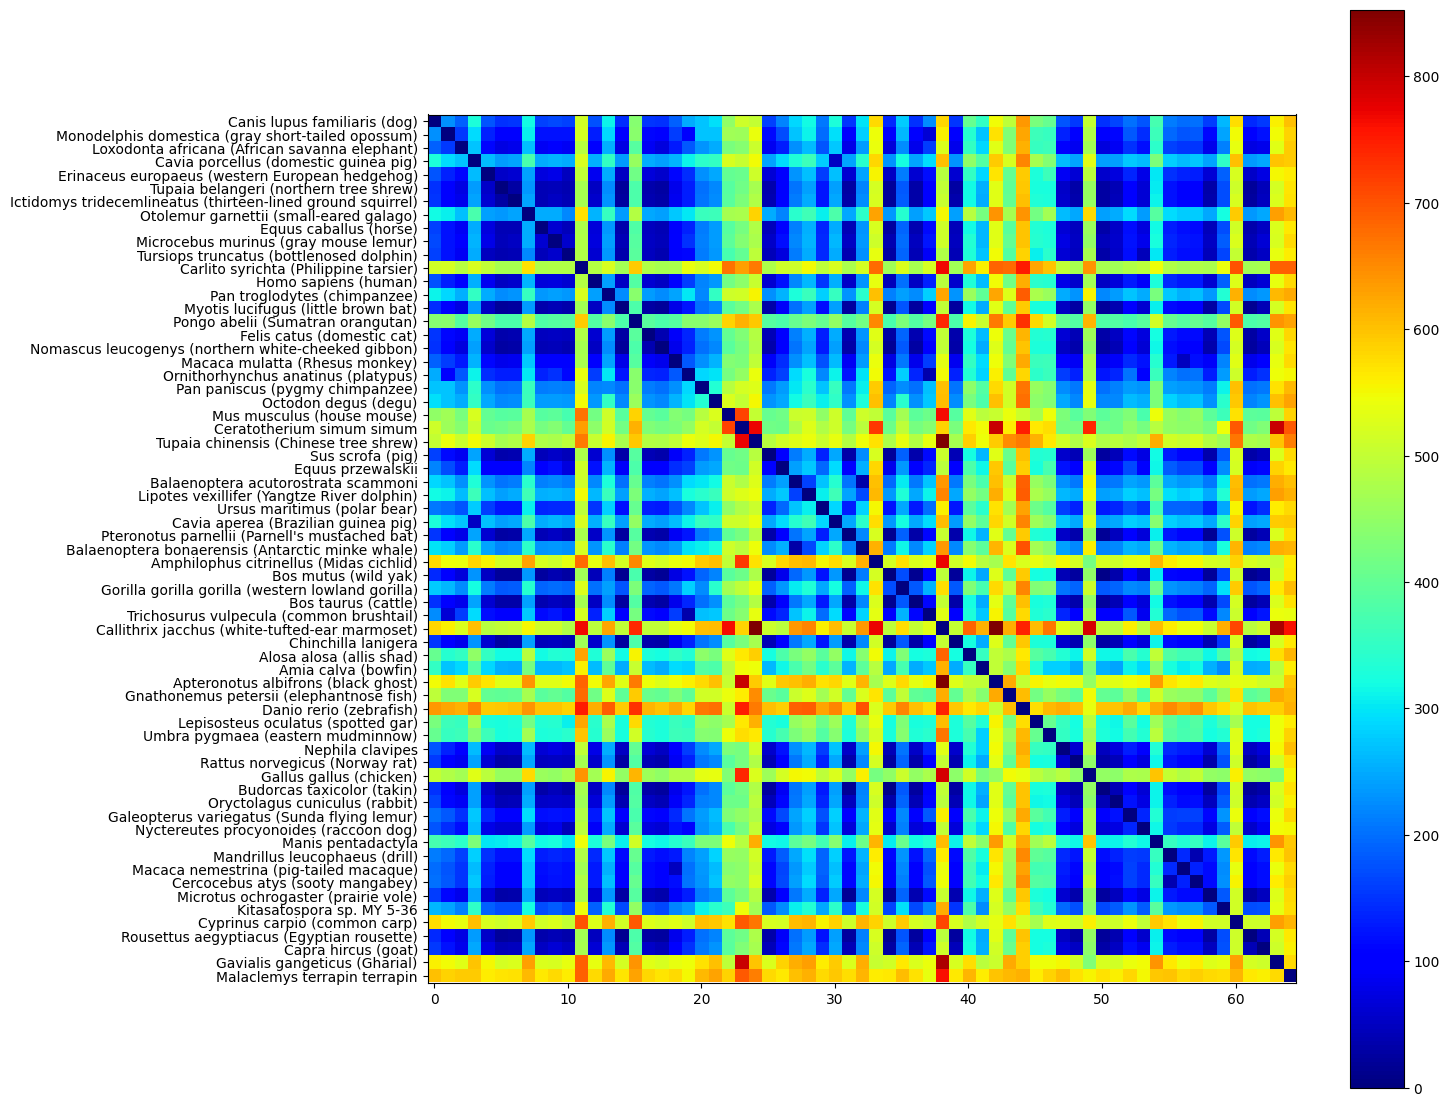

In [ ]:
fig = plt.figure(figsize=(14,14))
plt.imshow(distance_matrix, cmap = 'jet')
plt.colorbar()
plt.yticks(np.arange(distance_matrix.shape[0]), shortnames)
plt.show();

**Calculate Avg Distances against each other to get the Most Similar Sequence**

In [ ]:
# Step 1: Compute the average distance for each point
average_distances = np.mean(distance_matrix, axis=1)

# Step 2: Find the point with the minimum average distance
most_similar_point_index = np.argmin(average_distances)

print(f" Most similar sequence: {shortnames[most_similar_point_index]} \n Avg distance: {min(average_distances)} \n Index at the sequence list: {most_similar_point_index}")

 Most similar sequence: Bos mutus (wild yak) 
 Avg distance: 189.33846153846153 
 Index at the sequence list: 34


**Visualizing the similarity of the sequences**

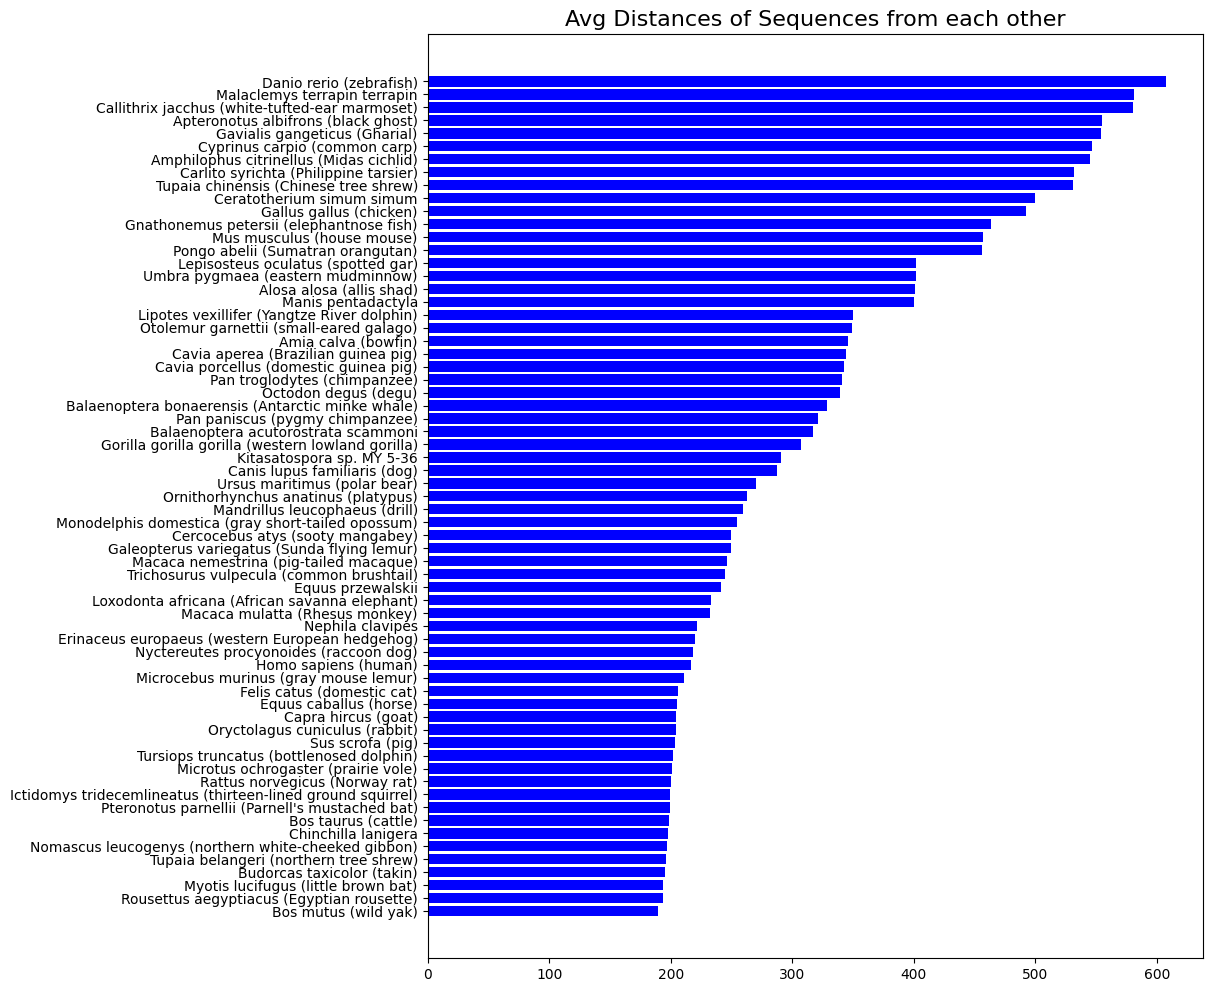

In [ ]:
sorted_average_distance_data = sorted(zip(shortnames, average_distances), key=lambda x: x[1])
sorted_shortnames, sorted_average_distances = zip(*sorted_average_distance_data)

# plot the sorted labels and avg distances as a horizontal bar plot
fig = plt.figure(figsize=(10,12))
plt.barh(sorted_shortnames, sorted_average_distances, color='blue')
plt.title('Avg Distances of Sequences from each other', fontsize = 16)
plt.show()

**Count total mutations for individual nucleotide base locations iteratively aligning all the sequences against selected sequence**

In [ ]:
# global alignment on most similar sequence
best_seq = speciesNameToSequence[unique_sequences[34]] # declare the most similar sequence
mutation_counter = [0] * len(best_seq)

# Do alignments with all the other sequences
for i in range(0, len(unique_sequences)):
  selected_seq = speciesNameToSequence[unique_sequences[i]]
  alignments = nw.global_align(best_seq, selected_seq, gap_open = -1, gap_extend = -1 ,matrix="alignment_score_matrix.txt")
  masterindex = 0
  for j, base in enumerate(alignments[0]):
    if base != alignments[1][j]:
      if base != '-' and alignments[1][j] != '-':
          mutation_counter[masterindex] += 1
    if base != "-":
      masterindex +=1

**Boxplot and Violin Plot of the Mutaion Counter**

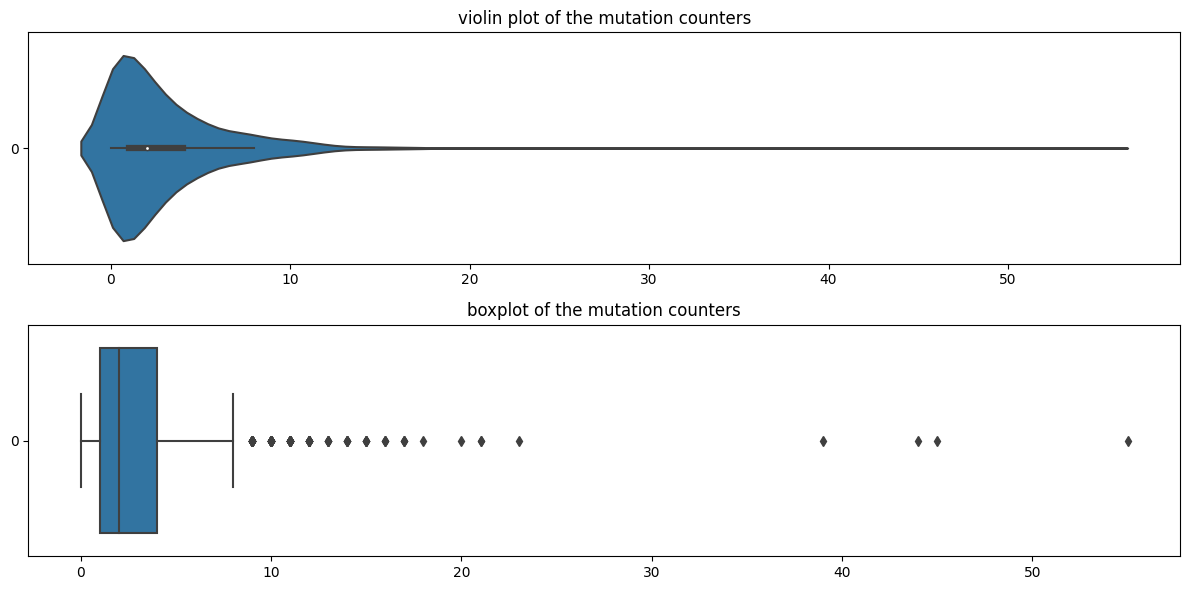

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
sb.violinplot(mutation_counter, orient='h')
plt.title('violin plot of the mutation counters')

plt.subplot(2, 1, 2)
sb.boxplot(mutation_counter, orient='h')
plt.title('boxplot of the mutation counters')

plt.tight_layout()
plt.show()

**(Heatmap) vs (Area Under Curve) of Mutation Counter for Individual Nucleotide Base Position.**

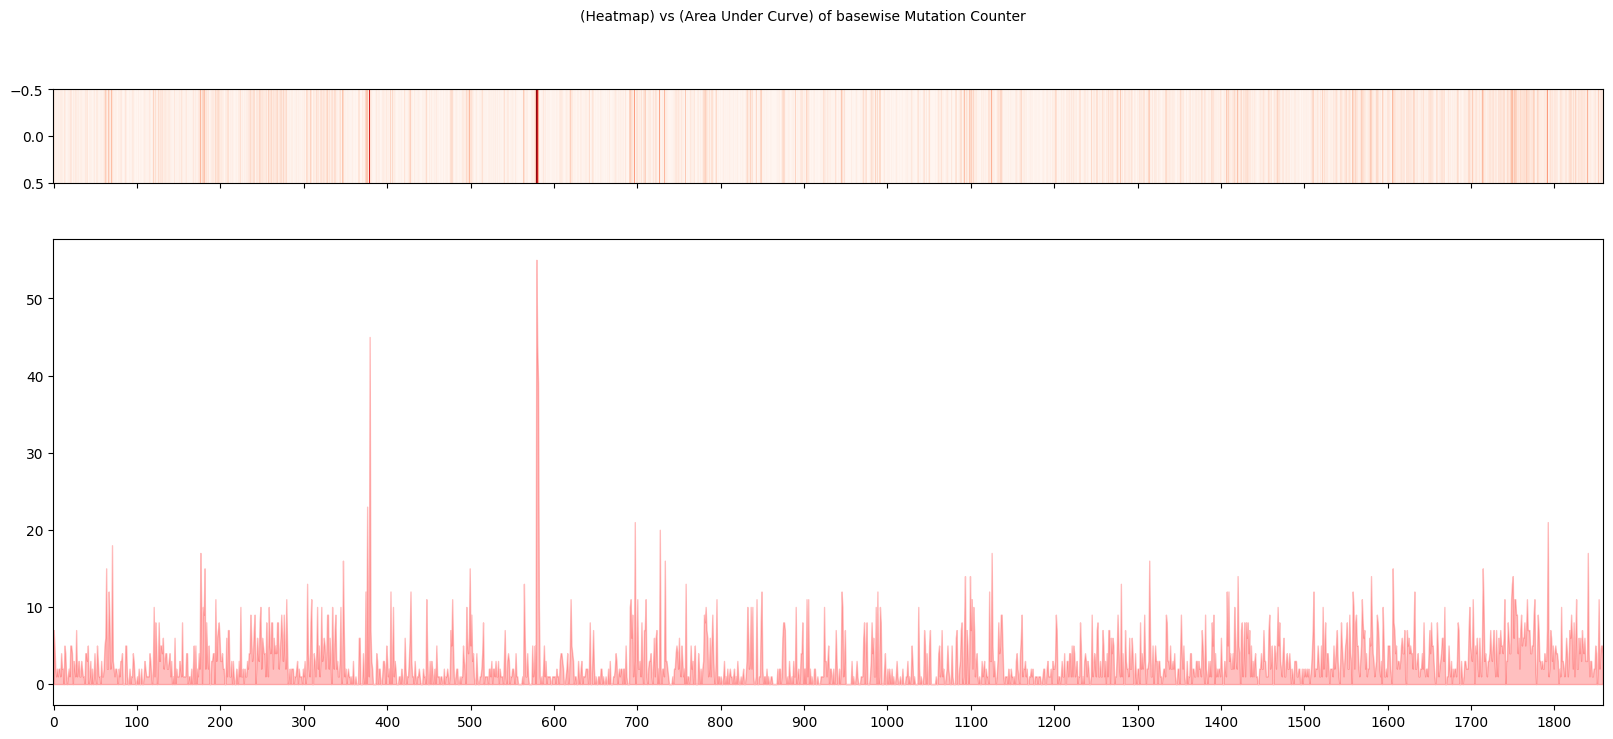

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [1, 5]})

ax1.imshow(np.array(mutation_counter).reshape((1, -1)), cmap='Reds', aspect='auto')

ax2.fill_between([i for i in range(len(mutation_counter))],mutation_counter, color='red', alpha=.25)
ax2.set_xticks(np.arange(0, len(mutation_counter)+1, 100))

fig.suptitle('(Heatmap) vs (Area Under Curve) of basewise Mutation Counter', size=10)
plt.show()

**Transform the mutation counters to reduce the effect of outliers**

Transformed Data: [1.26580343 0.929063   0.06654354 ... 0.929063   0.929063   0.7093371 ]


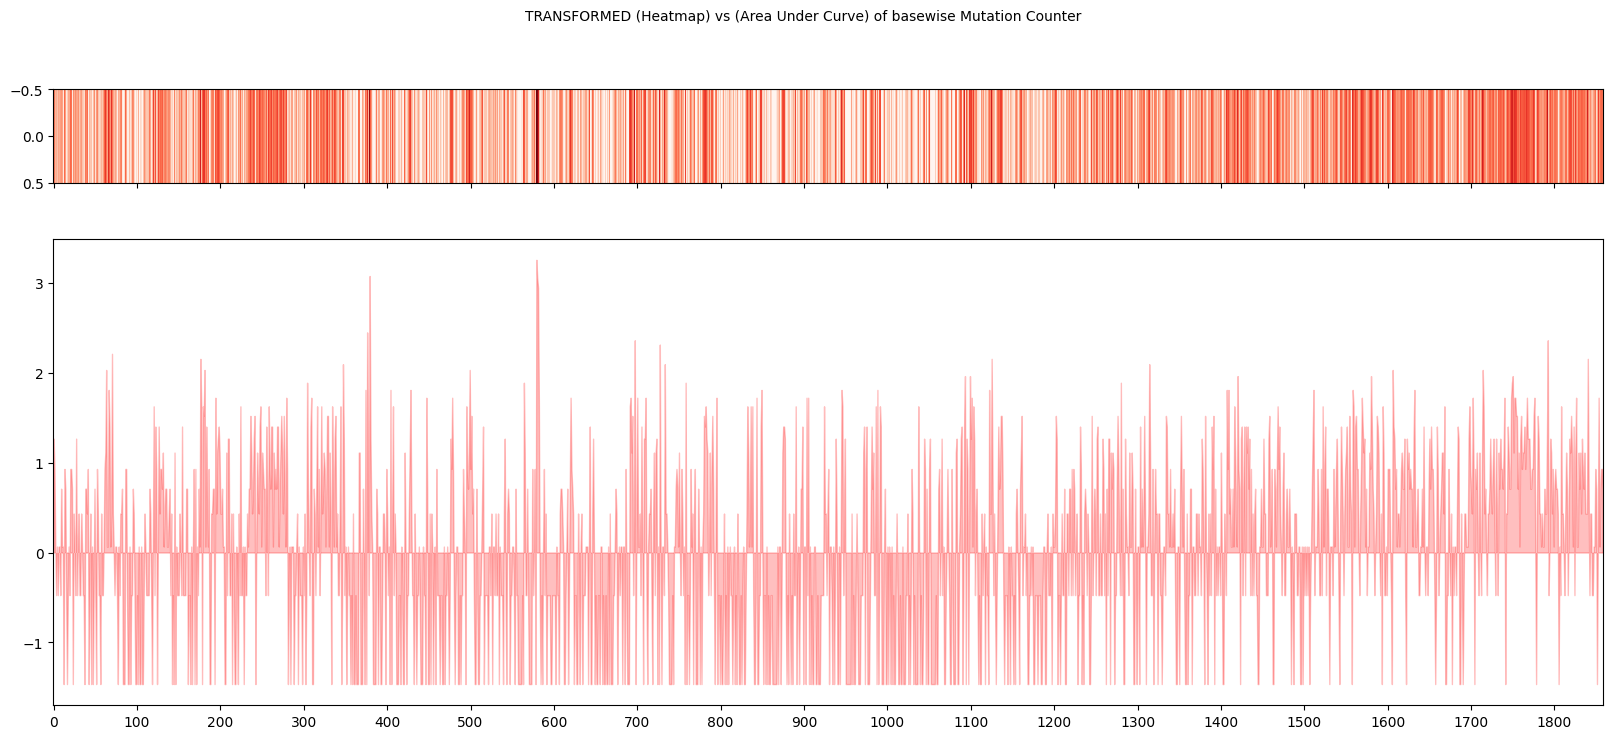

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Apply the PowerTransformer to reduce standard deviation
power_transformer = PowerTransformer(method='yeo-johnson')
transformed_data = power_transformer.fit_transform(np.array(mutation_counter).reshape(-1, 1)).flatten()
print("Transformed Data:", transformed_data)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8), sharex=True, gridspec_kw={'height_ratios': [1, 5]})

ax1.imshow(np.array(transformed_data).reshape((1, -1)), cmap='Reds', aspect='auto')

ax2.fill_between([i for i in range(len(transformed_data))],transformed_data, color='red', alpha=.25)
ax2.set_xticks(np.arange(0, len(transformed_data)+1, 100))

fig.suptitle('TRANSFORMED (Heatmap) vs (Area Under Curve) of basewise Mutation Counter', size=10)
plt.show()

**Discussion**

* Looking at our heatmesh graph above, we can see the frequency distribution of mutation for each base location. In the heat mesh, we see that the darker and more spread out lines refer to higher frequencies at that base. Therefore, the regions with darker and more spread out lines are most likely loops and the others are stems. However, we don't know the exact cutoff points for where these regions begini and end.

## Identify stems and loops

*   Brush off your implementations of the Smith-Waterman algorithm
*   Align any 18S sequence to its own reverse complement
*   Exhaustively search for alignments that indicate short stems



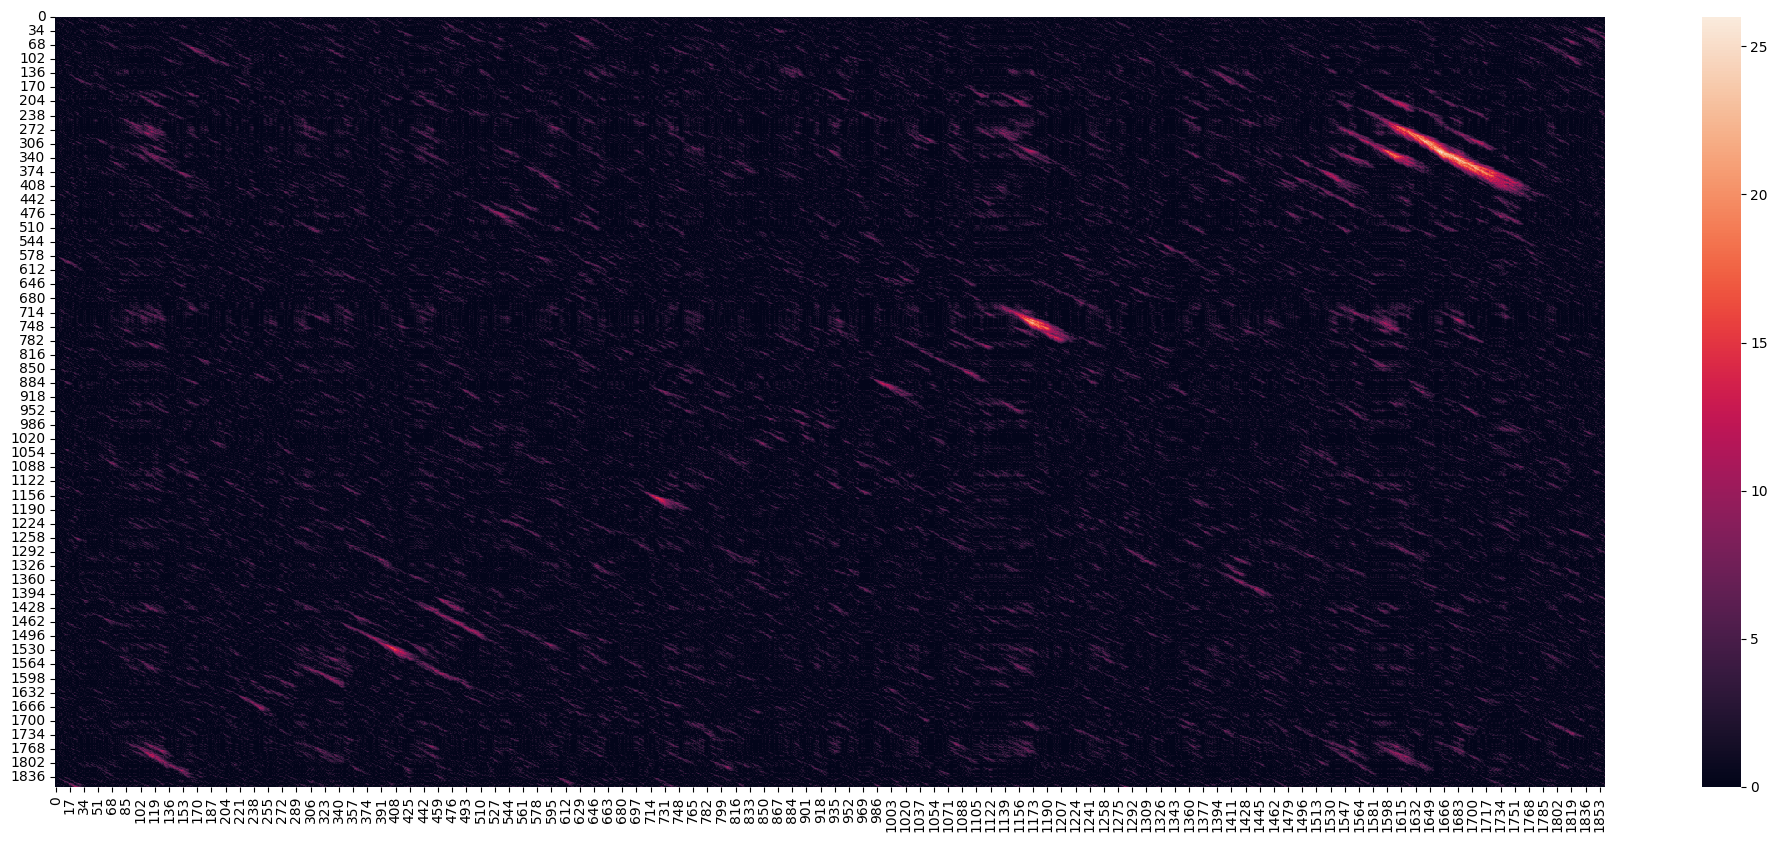

In [ ]:
from numpy import unravel_index

def SmithWaterman(query,subject,scorefunc):

  swmatrix = np.zeros ((len(query) + 1,len(subject) + 1))
  gap_score = -1.5

  for q in range(1,len(query)+1):
    for s in range(1,len(subject)+1):
      swmatrix[q,s] = max(swmatrix[q-1, s-1] + scorefunc(query[q-1], subject[s-1]), swmatrix[q-1, s] + gap_score, swmatrix[q, s-1] + gap_score, 0)

  alignment_score = np.max(swmatrix)
  alignment_score_indices = np.argwhere(swmatrix == alignment_score)
  q, s = alignment_score_indices[0]

  query_match_string = ""
  subject_match_string = ""

  while swmatrix[q, s] > 0:
    query_match_string += query[q-1]
    subject_match_string += subject[s-1]
    q -= 1
    s -= 1

  fig, ax = plt.subplots(figsize=(25,10))
  sns.heatmap(swmatrix)
  plt.show()
  return alignment_score

def match_score(a,b):
  if a == b:
    return 1
  else:
    return -1.5

def better_match_score(a,b):
  if (a == b):
    return 1
  elif (((a == "A" or a == "G") and (b == "A" or b == "G")) or ((a == "C" or a == "T") and (b == "C" or b == "T"))):
    return -1
  else:
    return -2

def getReverseComplement(sequence_input):
  reverse_complement = ""
  for i in range(len(sequence_input)):
    nucleotide = sequence_input[i]
    if nucleotide == 'A':
      reverse_complement += 'U'
    elif nucleotide == 'U':
      reverse_complement += 'A'
    elif nucleotide == 'G':
      reverse_complement += 'C'
    elif nucleotide == 'C':
      reverse_complement += 'G'
  return reverse_complement[::-1]

score = SmithWaterman(best_seq, getReverseComplement(best_seq), match_score)

## Compare mutation rates in conserved regions vs stems and loops

*   Test the hypothesis that substitutions and indels are more frequent in loops than stems.

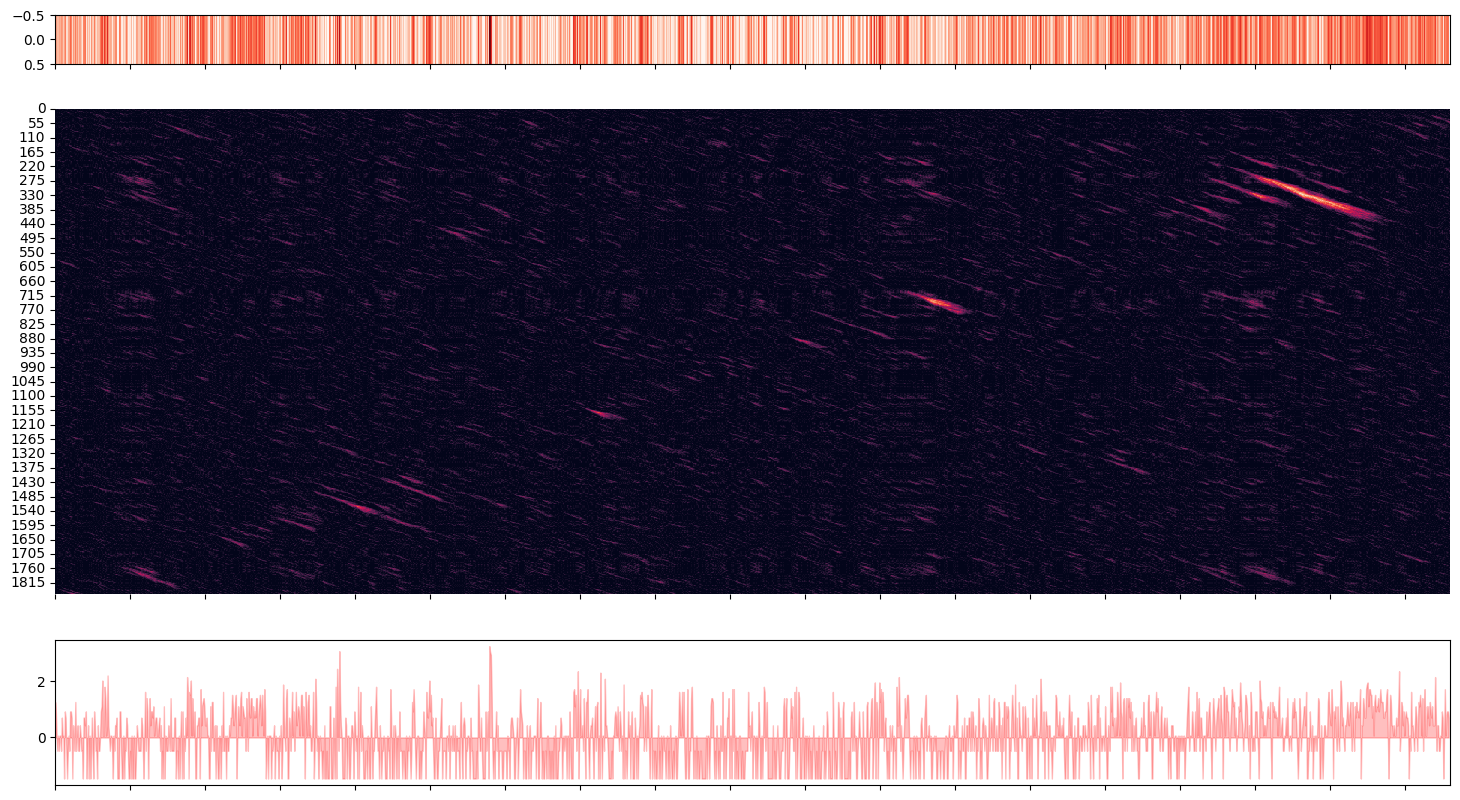

In [ ]:
from numpy import unravel_index

def SmithWaterman_and_Alignment_And_Compare_Mutation_Freq_output(query,subject,scorefunc):

  swmatrix = np.zeros ((len(query) + 1,len(subject) + 1)) #in Smith-Waterman, we only initialize to 0
  gap_score = -1.5

  for q in range(1,len(query)+1):
    for s in range(1,len(subject)+1):
      swmatrix[q,s] = max(swmatrix[q-1, s-1] + scorefunc(query[q-1], subject[s-1]), swmatrix[q-1, s] + gap_score, swmatrix[q, s-1] + gap_score, 0)

  alignment_score = np.max(swmatrix)
  alignment_score_indices = np.argwhere(swmatrix == alignment_score)
  q, s = alignment_score_indices[0]

  query_match_string = ""
  subject_match_string = ""

  while swmatrix[q, s] > 0:
    query_match_string += query[q-1]
    subject_match_string += subject[s-1]
    q -= 1
    s -= 1

  return swmatrix

score_matrix = SmithWaterman_and_Alignment_And_Compare_Mutation_Freq_output(best_seq, getReverseComplement(best_seq), match_score)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 10, 3]})

ax1.imshow(np.array(transformed_data).reshape((1, -1)), cmap='Reds', aspect='auto')

sns.heatmap(score_matrix, ax=ax2, cbar = False)

ax3.fill_between([i for i in range(len(transformed_data))],transformed_data, color='red', alpha=.25)
ax3.set_xticks(np.arange(0, len(transformed_data)+1, 100))

plt.show()

**Discussion**

* The hypothesis that substitutions and indels are more frequent in loops than stems is true. Substitutions and indels are considered mutations. Looking at the graphs above, which is a culmination of the visualizations from the previous two problems, we see a weak but visible correlation between high frequency and alignments. High mutation frequency regions align with the brighter regions on the heat map, showing that higher mutation frequencies correlate with occurrence of loops since  loops yield higher mismatch scores in the SmithWaterman algorithm. Therefore, we can conlude that substitutions and indels are more frequent in loops than stems.

## Faster alignment

The parasail library is an order of magnitude faster at performing alignments, and it also has semi-global alignment options, where insertions and deletions from the starts and ends of pairs of sequences are not punished.

Parasail vs nwalign3.

Documentation available here: https://github.com/jeffdaily/parasail-python


In [ ]:
# Install and import parasail
!pip install parasail
import parasail

Define a substitution matrix according to: https://github.com/jeffdaily/parasail-python#substitution-matrices

In [ ]:
matrixfile = open("matrix.txt",'w')
matrixfile.write("  A C G U *\nA 1 -1 -1 -1 -1\nC -1 1 -1 -1 -1\nG -1 -1 1 -1 -1\nU -1 -1 -1 1 -1\n* -1 -1 -1 -1 -1\n")
matrixfile.close()
scoringm = parasail.Matrix("matrix.txt")

max_score_per_base = 2
gap_open = 1
gap_extend = 1

seqA = "ACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGUACGU"*81
seqB = "ACGUACGUACGUACGUACGUACGUACGUACGUACGAAAAAAAAAAAAAAAAAAAAAAAAUAAACGUACGUAC"*41

res = parasail.sg(seqA, seqB, gap_open, gap_extend ,matrix=scoringm)
print(res.score)

1234


In [ ]:
print("Calculating distance matrix using all sequences...might take a while")

distance_matrix = np.zeros((len(unique_sequences),len(unique_sequences)))
num_alignments = 0
t0 = time.perf_counter()

max_score_per_base = 2
gap_open = 1
gap_extend = 1

with tqdm(total= (len(unique_sequences)-1) * len(unique_sequences)/2 ) as pbar:
    for x,seq1 in enumerate(unique_sequences):
        for y, seq2 in enumerate(unique_sequences):
            if x == y:
                distance_matrix[x,y] = 0
            if y > x:
                pbar.update(1)
                report = parasail.sg(speciesNameToSequence[seq1], speciesNameToSequence[seq2], gap_open, gap_extend,scoringm)
                distance_matrix[x,y]= report.score
                if num_alignments == 0:
                    num_alignments += 1
            else:
                distance_matrix[x,y] = distance_matrix[y,x]

print (f'\nCalculated {num_alignments} alignments in {time.perf_counter()-t0} seconds')

Calculating distance matrix using all sequences...might take a while


100%|██████████| 2080/2080.0 [00:34<00:00, 61.14it/s] 


Calculated 1 alignments in 34.02445311500014 seconds


**Performance Comparison**

* NWALIGN3 TIME: Calculated in ~60 seconds

* PARASAIL TIME: Calculated in ~35 seconds

* As we can see parasail library's scoring fuction took approximately 1/2 of the time taken by nwalign3. After going throuh parasail's documentation. For calculating our distance matrix, for nwalign, we first had to separately calculate the global alignment, and then we had to feed the two alignments into the scoring fuction. In contrast, Parasail has a global alignment scoring function that directly take two sequnces and return the score. Because of this and some internal optimization, parasail is able to acheive such efficiency.

## Different Clustering Methods

*   We cannot know the common ancestral sequences in the branches of the evolutionary tree
*   Finding linkage criterion that gives a good estimation?
*   Trying multiple different linkage criteria, and compare the resulting trees


**Perform 2 Hierarchical Clusterings (Complete Linkage & Cetroid Linkage) on Mammalian Distance Matrix**

<ipython-input-20-1b2cb3b1af73>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  centroid_linkage_matrix = linkage(distance_matrix, method='centroid')


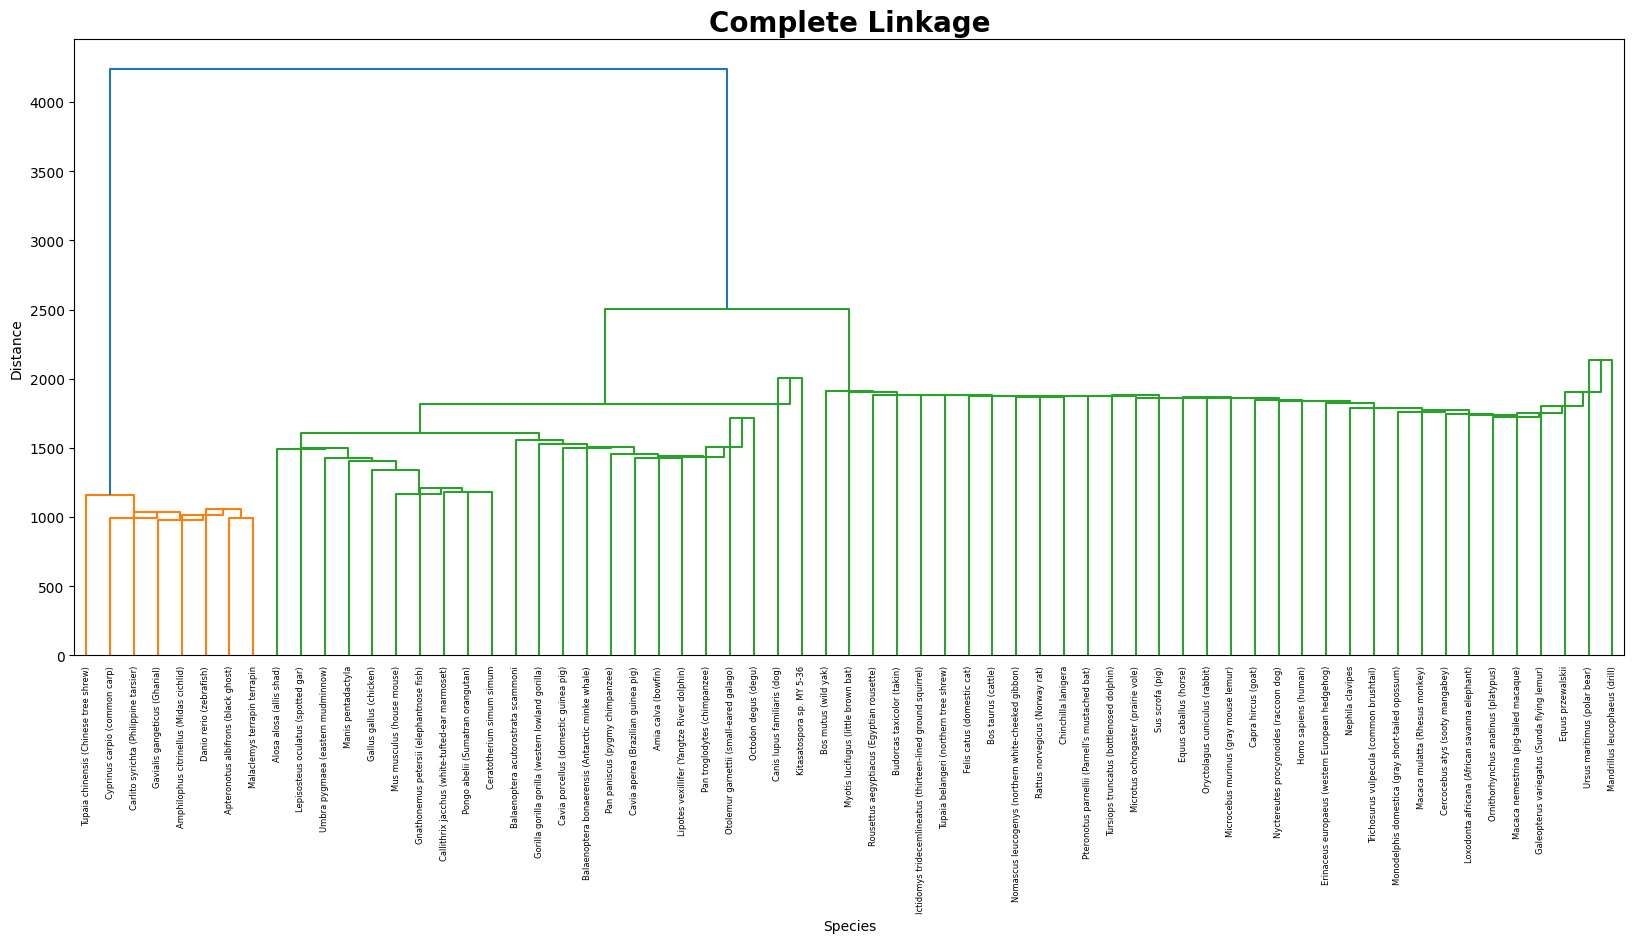

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

centroid_linkage_matrix = linkage(distance_matrix, method='centroid')

# Plot the dendrogram
plt.figure(figsize=(20,8))
dendrogram(centroid_linkage_matrix, labels=shortnames)
plt.title('Complete Linkage', fontsize=20, fontweight='bold')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.show()

<ipython-input-21-e67747ea5e7c>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  complete_linkage_matrix = linkage(distance_matrix, method='complete')


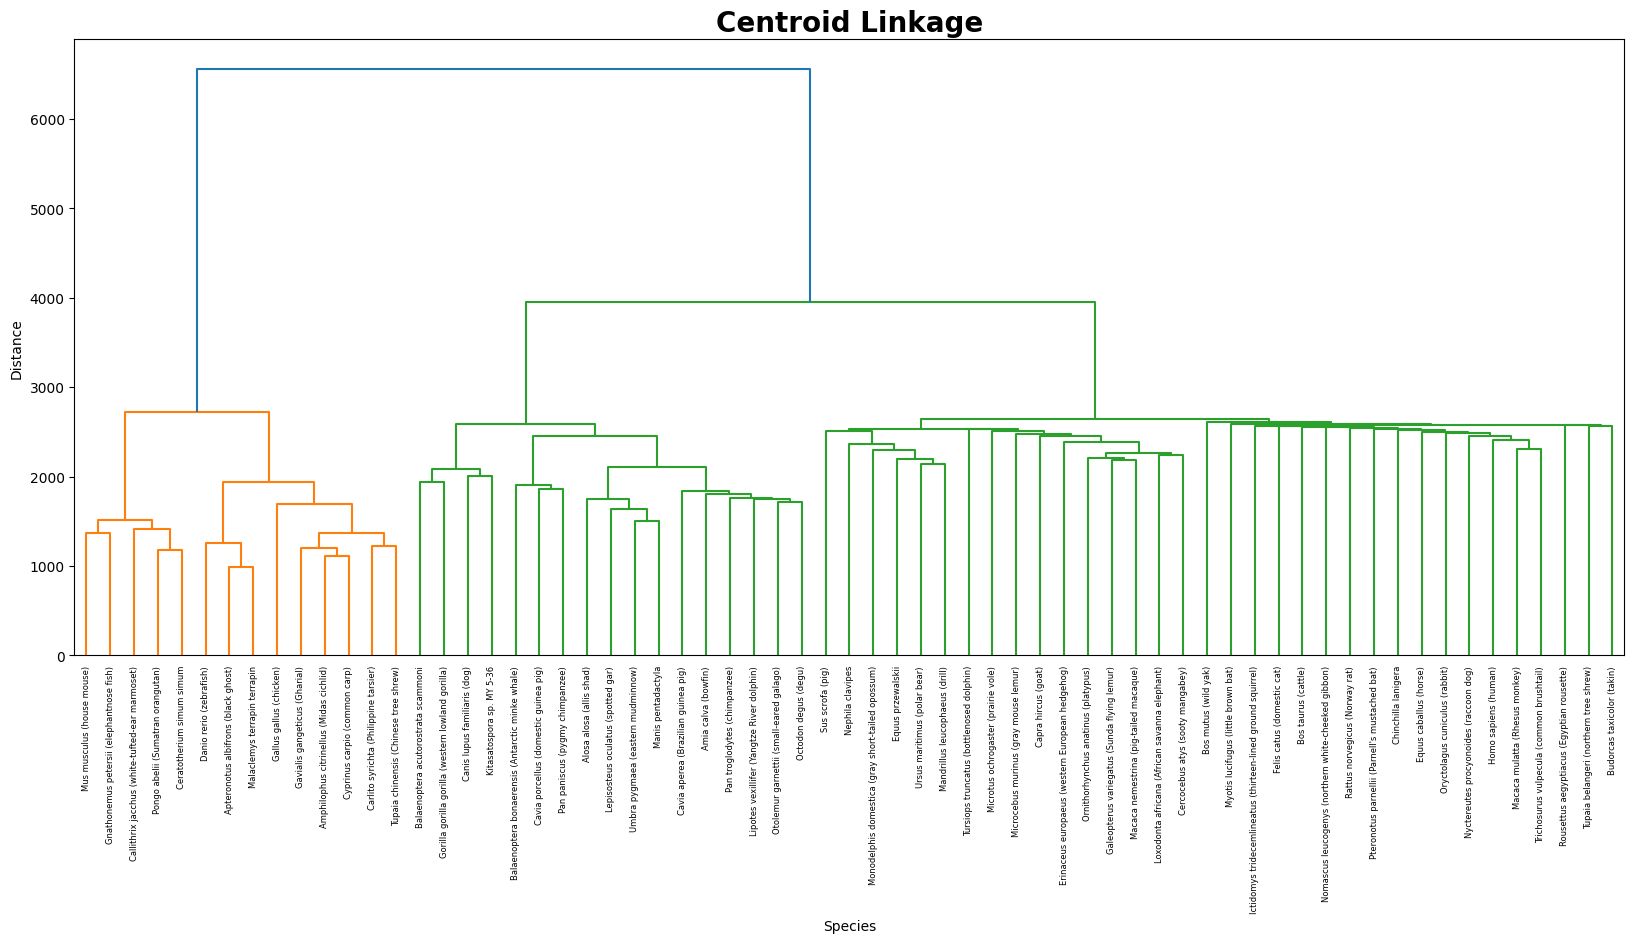

In [ ]:
complete_linkage_matrix = linkage(distance_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(20,8))
dendrogram(complete_linkage_matrix, labels=shortnames)
plt.title('Centroid Linkage', fontsize=20, fontweight='bold')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.show()

**Discussion**
* **Linkages Explored:** I explored 4 different linkages for clustering: single, complete, mean, and centroid.
* **Linkages Chosen:** I chose to complete and centoid linkage and compared them.
* **Centroid:** I found centroid and mean linkage to cluster almost identically, which is quite obsious since both of them are calculating the mean distance during different stages of forming individual links. The centroid performed quite well as its linkage criteria sits in between single and complete linkages.
* **Complete:** We know that complete linkage tends to perform better when we're performing clustering on data which doesn't sits far aparat in blobs. It acts almost like kMeans clustering as it forms a sperical neighbor to classify the data.
* **Contrast:** I think complete linkage performed well over the centroid linkage as out datapoint are scatter and does not sit in distinct clusters. The scattered formation of the datapoints translates to noise, which can be handled well by both centroid and complete linkage.

Moreover, genetic sequences exhibit certain range of variability and there tends to be not distint separations between group of points. For these type of data complete linkage tends to be better over single linkage.

Based on the these observations and interpretations, I conclude that complete linkage would be the optimal method out these 4 to cluster the sequences.

## Dataset Size (20 Points)

*   Exploringg a different branch of the tree of life, and comparing the results with the taxonomies present in the database

**Let's Compare 2 branches inside Vertebrata: Amphibia vs Aves**

**1. Create Distance Matrix for Amphibia**

In [ ]:
keywords = ['Amphibia']

newSpeciesNameToSequence = {}

newSpeciesNameToSequence = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(newSpeciesNameToSequence)} names match keywords")

new_unique_species = [] # A list of species names that are unique, like Homo Sapeins
new_unique_sequences = [] # a list of species that we will be using

minimum_sequence_length = 1600 #minimum length of 1600, because we are doing global and not local alignment...

for name in newSpeciesNameToSequence.keys():
    if ';' in name:
        speciesname = name.rpartition(';')[2] # remove the ID tags
        if len(newSpeciesNameToSequence[name]) > minimum_sequence_length: #minimum length of 1600, because we are doing global and not local alignment...
            if speciesname not in new_unique_species:
                new_unique_sequences.append(name)
                new_unique_species.append(speciesname)

new_unique_sequences = sorted(new_unique_sequences)

print (f'Number of new_unique species: {len(new_unique_species)}')
print (f'Number of new_sequences: {len(new_unique_sequences)}')

new_shortnames_ = [n.rpartition(';')[2] for n in new_unique_sequences]
print (', '.join(new_shortnames_))

Length: 1282 Shortname: >EF364234.1.1282 Scinax sp. 2 AAF-2007
Length: 1325 Shortname: >EF364368.1.1325 Atelopus flavescens (Cayenne stubfoot toad)
Length: 1288 Shortname: >EF364232.1.1288 Scinax sp. 1 AAF-2007
Length: 1292 Shortname: >EF364228.1.1292 Scinax ruber (red snouted treefrog)
Length: 1787 Shortname: >AJ867277.1.1794 Nitzschia amphibia
Length: 1777 Shortname: >JF900490.1.1777 Plethodon cinereus (red-backed salamander)
Length: 1890 Shortname: >AJ279506.1.1892 Ranodon sibiricus (Siberian salamander)
Length: 1879 Shortname: >AJ555450.1.1889 Odontophrynus americanus
Length: 1595 Shortname: >GAEI01002011.2.1596 Pseudacris regilla (Pacific treefrog)
Length: 1345 Shortname: >GAEG01003248.1.1345 Rana clamitans (bronze frog)
Length: 1828 Shortname: >GFBS01007143.1184.3011 Rana catesbeiana (American bullfrog)
Length: 1212 Shortname: >X59733.1.1826 Xenopus borealis (Kenyan clawed frog)
Length: 1562 Shortname: >HADU01013916.538.2099 Bombina bombina (fire-bellied toad)
Length: 1825 Shortn

In [ ]:
print("Calculating distance matrix using all sequences...might take a while")

new_distance_matrix = np.zeros((len(new_unique_sequences),len(new_unique_sequences)))
num_alignments = 0

t0 = time.perf_counter()

with tqdm(total= (len(new_unique_sequences)-1) * len(new_unique_sequences)/2 ) as pbar:
    for x,seq1 in enumerate(new_unique_sequences):
        for y, seq2 in enumerate(new_unique_sequences):
            if x == y:
                new_distance_matrix[x,y] = 0
            if y > x:
                pbar.update(1)
                alignment = nw.global_align(newSpeciesNameToSequence[seq1], newSpeciesNameToSequence[seq2], gap_open = -1, gap_extend = -1 ,matrix="alignment_score_matrix.txt")
                score = nw.score_alignment(alignment[0], alignment[1], gap_open = 1, gap_extend = 1 ,matrix="distance_score_matrix.txt")
                new_distance_matrix[x,y]= score
                if num_alignments == 0:
                    num_alignments += 1
            else:
                new_distance_matrix[x,y] = new_distance_matrix[y,x]

print (f'\nCalculated {num_alignments} alignments in {time.perf_counter()-t0} seconds')

Calculating distance matrix using all sequences...might take a while


100%|██████████| 45/45.0 [00:02<00:00, 18.79it/s]


Calculated 1 alignments in 2.417644950999602 seconds


**2.Create Distance Matrix for Aves**

In [ ]:
keywords = ['Aves']

newSpeciesNameToSequence2 = {}

newSpeciesNameToSequence2 = get_fasta_sequences_from_zip(zipped_sequence_filename)
print (f"{len(newSpeciesNameToSequence2)} names match keywords")

new_unique_species2 = [] # A list of species names that are unique, like Homo Sapeins
new_unique_sequences2 = [] # a list of species that we will be using

minimum_sequence_length = 1600 #minimum length of 1600, because we are doing global and not local alignment...

for name in newSpeciesNameToSequence2.keys():
    if ';' in name:
        speciesname = name.rpartition(';')[2] # remove the ID tags
        if len(newSpeciesNameToSequence2[name]) > minimum_sequence_length: #minimum length of 1600, because we are doing global and not local alignment...
            if speciesname not in new_unique_species2:
                new_unique_sequences2.append(name)
                new_unique_species2.append(speciesname)

new_unique_sequences2 = sorted(new_unique_sequences2)

print (f'Number of new_unique species: {len(new_unique_species2)}')
print (f'Number of new_sequences: {len(new_unique_sequences2)}')

new_shortnames_2 = [n.rpartition(';')[2] for n in new_unique_sequences2]
print (', '.join(new_shortnames_2))

Length: 1377 Shortname: >JN084162.1.1377 Microbacterium flavescens
Length: 1467 Shortname: >AB004716.1.1467 Microbacterium flavescens
Length: 1372 Shortname: >AJ308320.1.1372 Pseudomonas flavescens
Length: 1325 Shortname: >EF364368.1.1325 Atelopus flavescens (Cayenne stubfoot toad)
Length: 1454 Shortname: >X52932.1.1454 Mycobacterium flavescens
Length: 1727 Shortname: >AB023475.1.1727 Metschnikowia agaves
Length: 1774 Shortname: >AB085797.1.1782 Papiliotrema flavescens
Length: 1409 Shortname: >X82060.1.1409 Corynebacterium flavescens
Length: 1774 Shortname: >AB085796.1.1782 Papiliotrema flavescens
Length: 1427 Shortname: >EU730942.1.1427 Microbacterium flavescens
Length: 1482 Shortname: >X84441.1.1489 Corynebacterium flavescens
Length: 1439 Shortname: >KF876899.1.1439 Nocardiopsis flavescens
Length: 1471 Shortname: >Y17232.1.1471 Microbacterium flavescens
Length: 1480 Shortname: >L06082.1.1486 Conservatibacter flavescens
Length: 1480 Shortname: >L06168.1.1486 Neisseria flavescens
Lengt

In [ ]:
print("Calculating distance matrix using all sequences...might take a while")

new_distance_matrix2 = np.zeros((len(new_unique_sequences2),len(new_unique_sequences2)))
num_alignments = 0

t0 = time.perf_counter()

with tqdm(total= (len(new_unique_sequences2)-1) * len(new_unique_sequences2)/2 ) as pbar:
    for x,seq1 in enumerate(new_unique_sequences2):
        for y, seq2 in enumerate(new_unique_sequences2):
            if x == y:
                new_distance_matrix2[x,y] = 0
            if y > x:
                pbar.update(1)
                alignment = nw.global_align(newSpeciesNameToSequence2[seq1], newSpeciesNameToSequence2[seq2], gap_open = -1, gap_extend = -1 ,matrix="alignment_score_matrix.txt")
                score = nw.score_alignment(alignment[0], alignment[1], gap_open = 1, gap_extend = 1 ,matrix="distance_score_matrix.txt")
                new_distance_matrix2[x,y]= score
                if num_alignments == 0:
                    num_alignments += 1
            else:
                new_distance_matrix2[x,y] = new_distance_matrix2[y,x]

print (f'\nCalculated {num_alignments} alignments in {time.perf_counter()-t0} seconds')

Calculating distance matrix using all sequences...might take a while


100%|██████████| 105/105.0 [00:03<00:00, 30.22it/s]


Calculated 1 alignments in 3.484331363999445 seconds


**Compare Distance Matrices: Aves vs Amphibia**

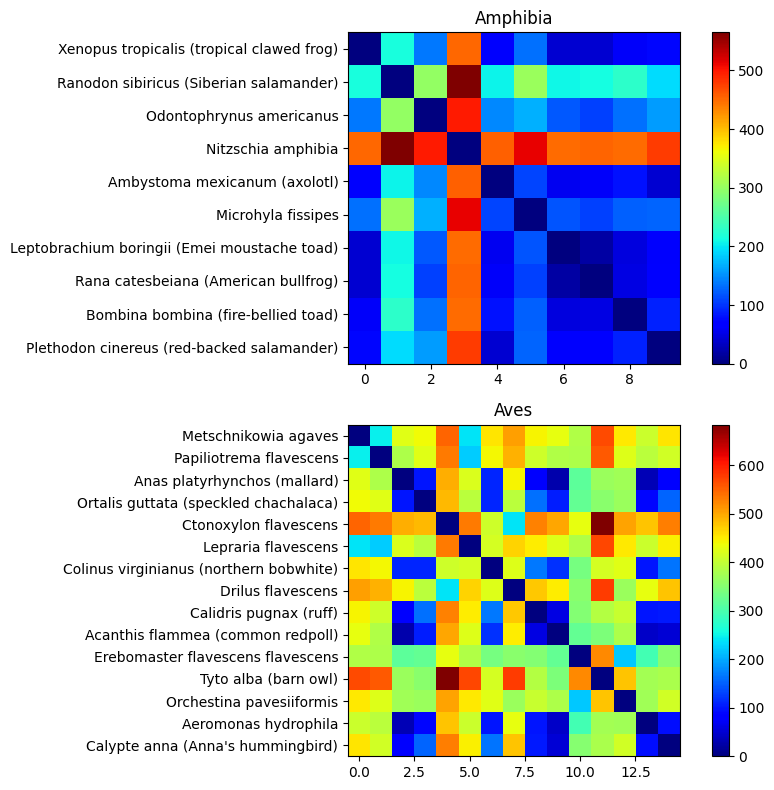

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

im1 = axs[0].imshow(new_distance_matrix, cmap='jet')
axs[0].set_title('Amphibia')
axs[0].set_yticks(np.arange(new_distance_matrix.shape[0]))
axs[0].set_yticklabels(new_shortnames_)
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(new_distance_matrix2, cmap='jet')
axs[1].set_title('Aves')
axs[1].set_yticks(np.arange(new_distance_matrix2.shape[0]))
axs[1].set_yticklabels(new_shortnames_2)
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()

**DISCUSSION**

* We found some interesting observation in both groups. We see that all the sequences of the Amphibians are closely related to eachother except one; Nitzschia Amphibia is surprisingly very different from all its group members.

* In contrast to Amphibia, we see that Aves are has more vaiance in similarity within the group. This hints us that Aves might be more internally diverse compared Amphibia.